In [1]:
DIR = 'flickr30k_images'

In [1]:
import tensorflow as tf
from keras.models import Model, load_model
from keras import layers
import keras.backend as K
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import cv2
import math
import vgg19
print(tf.version.VERSION)

Using TensorFlow backend.


2.1.0


In [3]:
H,W,C = 224,224,3
train_images_list = os.listdir(DIR + '/flickr30k_images/')
sample_size = int(0.99*len(train_images_list))
train_images = np.zeros((len(train_images_list),H,W,C))
arange = np.array(np.arange(sample_size),dtype='int')

j = 0
for i in train_images_list:
    train_images[j] = np.array(cv2.resize(plt.imread(DIR + '/flickr30k_images/' + i),(H,W)))
    j = j+1
    

In [4]:
start_tag = '<s>'
end_tag = '<e>'

def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names


def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = i.lower()
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(arr)
    set_arr = list(set(arr))
    new_set = list()
    for word in set_arr:
        if arr.count(word) > 10 or word == '<s>' or word == '<e>':
            new_set.append(word)
    arr = new_set
    arr.append('<OTHER>')
    vocab_size = len(arr)
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image_name'] == i]['comment'].iat[0])
    return caption



In [5]:
train_captions = pd.read_csv(DIR + '/results.csv', delimiter='|')
train_captions.columns = ['image_name', 'comment_number', 'comment']
captions = np.array(images_map_caption(train_images_list[:sample_size], train_captions))

In [6]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)
print(vocab_size)

del train_captions, captions
## train_images = images to train on
## sentences = captions to train on
## vocab_size = total vocab
## fwd_dict = word->number and rev_dict = number->word in RNN
## Start word: <s>, End word: <e>

1227


In [2]:
def build_model(): ##Input partial caption is word indexes
    embedder = layers.Embedding(vocab_size, 1000)

    GRU = layers.GRU(
        vocab_size-1, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
        kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
        bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        recurrent_constraint=None, bias_constraint=None, dropout=0.0,
        recurrent_dropout=0.0, implementation=2, return_sequences=False,
        return_state=False, go_backwards=False
        )

    img_v = layers.Input(shape=(None,1000))

    words_hot_encoding = layers.Input(shape=(None,))
    words_v = embedder(words_hot_encoding)

    gru_input = layers.concatenate([img_v,words_v],axis=1)
    gru_output = GRU(gru_input)
    output = layers.Softmax()(gru_output)

    return Model(inputs=[img_v,words_hot_encoding],outputs=output)

def build_model_experimental(): ##Input partial captial is hot-encoded numpy array
    word_encoder = layers.Conv1D(image_attributes.shape[2],vocab_size,padding='valid')

    GRU = layers.GRU(
        vocab_size-1, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
        kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
        bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        recurrent_constraint=None, bias_constraint=None, dropout=0.0,
        recurrent_dropout=0.0, implementation=2, return_sequences=False,
        return_state=False, go_backwards=False
        )

    img_v = layers.Input(shape=(None,1000))

    words_hot_encoding = layers.Input(shape=(None,vocab_size))
    words_v = word_encoder(words_hot_encoding)

    gru_input = layers.concatenate([img_v,words_v],axis=1)
    gru_output = GRU(gru_input)
    output = layers.Softmax()(gru_output)

    return Model(inputs=[img_v,words_hot_encoding],outputs=output)

In [3]:
model_path = "gru_model%i.h5" % (vocab_size)
if os.path.exists(model_path):
    GRU_Model = load_model(model_path)
else:
    GRU_Model = build_model()

In [4]:
optimizer = keras.optimizers.Adam(learning_rate=0.00000005, beta_1=0.9, beta_2=0.999, amsgrad=False) 
##0.0001 <= lr <= 0.00001
loss_function = keras.losses.categorical_crossentropy

GRU_Model.compile(optimizer, loss=loss_function)
GRU_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None, 1000)   0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1000)   1228000     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1000)   0           input_1[0][0]                    
                                                                 embedding_1[0][0]          

In [165]:
def nums_to_words(nums_array):
    words_array = []
    for i in nums_array:
        if i in rev_dict:
            words_array.append(rev_dict[i])
    return words_array

def convert(s): 
    new = ""   
    for i in range(len(s)):
        x = s[i]
        if x != '<s>' and x != '<e>':
            if i > 1 and s[i] != ',' and s[i] != '.':
                new += " "
            new += x
    return new 

def image_caption(test_number,image_attributes, n=5,max_length=20):
    done = False

    ##Make top 5 array with 5 [sentence, score] where score is the sum of softmax probabilities of all words in sentence so far.
    ##Initialize the array with the top 5 combinations after the start word, <s>
    ##Sort top 5 by probability scores
    ##Continue to expand from top of top 5 until you reach the case that they all end with <e>
    ##When expanding sentence, expand to its top 5. Compare all 5 with minimum scores in current top 5. Replace as necessary.
    ##Re-sort top 5 and continue to expand
    topn_words = np.array([fwd_dict['<s>']])
    topn_scores = np.array([1.0])


    init_pred = GRU_Model.predict(x=[image_attributes[test_number][np.newaxis],topn_words[np.newaxis]]).reshape((-1,))
    topn_words = topn_words[np.newaxis,:] + np.zeros((n,topn_words.shape[0]))
    topn_scores = topn_scores[np.newaxis,:] + np.zeros((n,1))

    topn_words = np.concatenate((topn_words,init_pred.argsort()[-n:][::-1][:,np.newaxis]),axis=1).tolist() ##shape = [5][sentencelength]
    topn_scores = topn_scores * np.sort(init_pred)[-n:][::-1].reshape((-1,1)) ##shape = 5

    while done == False:
        done = True
        for i in range(len(topn_words)):
            num_words = np.array(topn_words[i])
            num_scores = topn_scores[i]
            if num_words.shape[0] <= max_length and num_words[-1] != fwd_dict['<e>']:
                
                init_pred = GRU_Model.predict(x=[image_attributes[test_number][np.newaxis],num_words[np.newaxis]]).reshape((-1,))
                num_words = num_words[np.newaxis,:] + np.zeros((n,num_words.shape[0]))
                num_scores.reshape((-1,1))
                num_scores = (num_scores[np.newaxis,:] + np.zeros((n,1)))

                num_words = np.concatenate((num_words,init_pred.argsort()[-n:][::-1][:,np.newaxis]),axis=1).tolist() ##shape = [5][sentencelength]
                num_scores = num_scores * np.sort(init_pred)[-n:][::-1].reshape((-1,1)) ##shape = 5

                topn_words[i] = num_words[0]
                topn_scores[i] = num_scores[0]
                for j in range(1,len(num_words),1):
                    for k in range(0,len(topn_words),1):
                        if num_scores[j] > topn_scores[k]:
                            topn_words[k] = num_words[j]
                            topn_scores[k] = num_scores[j]
                            break
        for i in range(len(topn_words)):
            sentence = np.array(topn_words[i])
            if sentence.shape[0] <= max_length and sentence[-1] != fwd_dict['<e>']:
                done = False
                break
    testsentence = topn_words[np.argmax(topn_scores)]
    return convert(nums_to_words(testsentence))


In [27]:
epoch_tracker = 0
batch_tracker = 0

In [159]:
epochs = 100
batch_size = 20
save_frequency_batch = 5
save_frequency_epoch = 1
save_model_batch_to = "gru_model%i.h5" % (vocab_size)
save_model_epoch_to = "gru_model2%i.h5" % (vocab_size)

test_number = 0
vgg = vgg19.Vgg19()
vgg.build(train_images[test_number:test_number+1].astype('float32'))
image_attributes_test = vgg.fc8.numpy().reshape((-1,1,1000)) ##image feature vector to feed into GRU

num_batches = int(math.ceil(sample_size/batch_size))
for j in range(epoch_tracker,epochs):
    if batch_tracker >= (num_batches-1):
        np.random.shuffle(arange)
        batch_tracker = 0
    epoch_tracker = j
    print("EPOCHS %i:" %(j))
    
    for batch in range(batch_tracker,num_batches):
        batch_tracker = batch
        s_i = int(batch*batch_size)
        e_i = s_i+batch_size
        vgg = vgg19.Vgg19()
        vgg.build(train_images[arange[s_i:e_i]].astype('float32'))
        image_attributes = vgg.fc8.numpy().reshape((-1,1,1000)) ##image feature vector to feed into GRU
        i = 0
        loss = []
        sentence_loss = []
        print(image_caption(test_number,image_attributes,n=3,max_length=10))
        target = np.zeros((1,vocab_size))
        for k in arange[s_i:e_i]:
            sentence = sentences[k]
            if sentence_loss != []:
                loss.append(np.mean(np.array(sentence_loss)))
                del sentence_loss
            sentence_loss = []
            if sentence == None:
                continue
            words = []
            for word in sentence:
                if word in fwd_dict:
                    target[:,fwd_dict[word]] = 1
                else:
                    target[:,fwd_dict['<OTHER>']] = 1
                if word != '<s>':
                    sentence_loss.append(GRU_Model.train_on_batch(x=[image_attributes[i][np.newaxis],np.array(words)[np.newaxis]],y=target))
                words.append(fwd_dict[word])
                if word in fwd_dict:
                    target[:,fwd_dict[word]] = 0
                else:
                    target[:,fwd_dict['<OTHER>']] = 0
            i = i+1
        del image_attributes
        print("batch_loss = %f" %(np.mean(np.array(loss))))
        if batch%save_frequency_batch == 0:
            GRU_Model.save(save_model_batch_to)
    if (j%save_frequency_epoch) == 0:
        print("Saving Model...")
        GRU_Model.save(save_model_epoch_to)
        print("Done Saving Model")


EPOCHS 4:
the top in black shirt standing outside in some.
batch_loss = 5.706437
an older man sitting in the man sitting on some.
batch_loss = 5.782820
an older man sitting in the man sitting on some.
batch_loss = 5.725204
an older man sitting in the man sitting on some.
batch_loss = 5.756696
men wearing a girl wearing blue shirt standing outside in some.
batch_loss = 5.913196
people in a girl wearing blue shirt standing outside in some.
batch_loss = 5.765370
a girl sitting in the camera.
batch_loss = 5.820151
a girl sitting in the camera.
batch_loss = 5.717189
a girl sitting in the camera.
batch_loss = 5.740940
a girl sitting in the camera.
batch_loss = 5.739653
a girl sitting in the camera.
batch_loss = 5.799415
a girl sitting in the camera.
batch_loss = 5.777284
a girl sitting in the camera.
batch_loss = 5.727572
a girl sitting in the camera.
batch_loss = 5.772448
a girl sitting in the camera.
batch_loss = 5.739675
a girl sitting in the camera.
batch_loss = 5.755049
a girl sitting i

batch_loss = 5.834888
vests in front of the camera.
batch_loss = 5.718860
the other in front of him.
batch_loss = 5.803278
the other in front of him.
batch_loss = 5.800397
vests in front of the camera.
batch_loss = 5.840181
the other in front of him.
batch_loss = 5.783237
the other in front of him.
batch_loss = 5.803159
the other in front of him.
batch_loss = 5.774843
one man in front of her head in the camera.
batch_loss = 5.794926
the other in front.
batch_loss = 5.758760
the other in front.
batch_loss = 5.724674
vests in front of the camera.
batch_loss = 5.787210
vests in front of the camera.
batch_loss = 5.708389
the other in front.
batch_loss = 5.761241
three men wearing a girl and a girl sitting on some.
batch_loss = 5.831316
the other in front.
batch_loss = 5.842399
the other in front.
batch_loss = 5.703945
three men wearing a girl and a girl sitting on some.
batch_loss = 5.831899
the side of a girl wearing blue shirt standing outside.
batch_loss = 5.774466
three young woman sit

batch_loss = 5.796179
one man and a girl and a girl sitting on some.
batch_loss = 5.827888
one man and a girl and a girl sitting on some.
batch_loss = 5.776001
grass in the man standing outside in some.
batch_loss = 5.772956
grass in the man standing outside in some.
batch_loss = 5.708560
grass in the man standing outside in some.
batch_loss = 5.856303
a girl sitting in front.
batch_loss = 5.786837
grass in the man standing outside in blue shirt in his hand.
batch_loss = 5.776104
grass in the man standing outside in some.
batch_loss = 5.749828
three young woman standing outside in the ball.
batch_loss = 5.760693
three young woman standing outside in the ball.
batch_loss = 5.759532
three young woman standing outside in the ball.
batch_loss = 5.760366
vests in front of the camera.
batch_loss = 5.858115
vests in front of the camera.
batch_loss = 5.750677
one man sitting on some.
batch_loss = 5.669383
one man sitting on some.
batch_loss = 5.775295
men wearing a girl and a girl wearing a gi

vests in front of the man standing outside in some.
batch_loss = 5.723327
a girl sitting in front
batch_loss = 5.761175
a girl sitting in front
batch_loss = 5.780336
a girl sitting in front


KeyboardInterrupt: 

an older man a girl sitting on her hands.


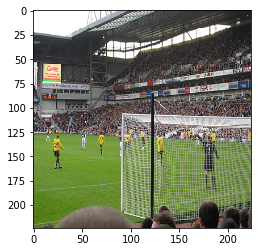

In [189]:
test_number = train_images.shape[0]-23

if test_number < train_images.shape[0]:
    plt.imshow(np.array(train_images[test_number],dtype='uint8'))
    vgg = vgg19.Vgg19()
    vgg.build(train_images[test_number:test_number+1].astype('float32'))
    image_attributes_test = vgg.fc8.numpy().reshape((-1,1,1000)) ##image feature vector to feed into GRU
    print(image_caption(0,image_attributes_test,n=10))
else:
    print("test_number is too large")

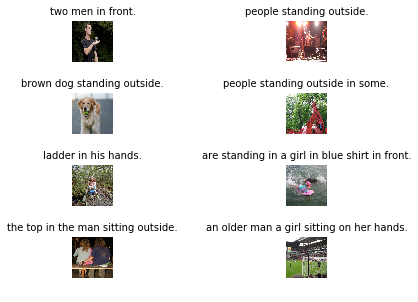

In [202]:
f, ax = plt.subplots(4,2)

test_number = train_images.shape[0]-30

if test_number < train_images.shape[0]-8:
    plt.imshow(np.array(train_images[test_number],dtype='uint8'))
    vgg = vgg19.Vgg19()
    vgg.build(train_images[test_number:test_number+9].astype('float32'))
    image_attributes = vgg.fc8.numpy().reshape((-1,1,1000)) ##image feature vector to feed into GRU
else:
    print("test_number is too large")



for i in range(2):
    a = int(i*4)
    ax[0,i].imshow(np.array(train_images[test_number+a],dtype='uint8'));  ax[0,i].axis('Off'); ax[0,i].set_title(image_caption(a,image_attributes,n=10), size=10);
    ax[1,i].imshow(np.array(train_images[test_number+a+1],dtype='uint8'));  ax[1,i].axis('Off'); ax[1,i].set_title(image_caption(a+1,image_attributes,n=10), size=10);
    ax[2,i].imshow(np.array(train_images[test_number+a+2],dtype='uint8'));  ax[2,i].axis('Off'); ax[2,i].set_title(image_caption(a+2,image_attributes,n=10), size=10);
    ax[3,i].imshow(np.array(train_images[test_number+a+3],dtype='uint8'));  ax[3,i].axis('Off'); ax[3,i].set_title(image_caption(a+3,image_attributes,n=10), size=10);
f.tight_layout(pad=0)
plt.show()